# Exploring cybersecurity attacks

## Introduction to the Case study

**Business context.** You are the cybersecurity expert of the Central Statistics Office (CSO) at the Ministry of Statistics and Programme Implementation. In the last month, some cybersecurity events with different durations and patterns have been registered.

**Problem statement.** You want to identify <i>"what are the most common cybersecurity attacks, the most accessed logical ports, and the visible patterns?"</i>

**Analytical context** The data to be processed has been obtained by aggregating data provided by a company's technology department, which includes network flow data produced by nine different types of attacks within everyday user activities. Using your data analysis skills, identify what are the most common cybersecurity attacks occurring in the measured time frame, the most accessed logical ports, and the visible patterns of these attacks.

## Importing the packages for data analysis

We will use four main packages: ```pandas```,``` numpy```, ```matplotlib``` and ``` seaborn```, and the `scipy` library. Let's import these packages using the keyword ``import``. We will change the name from ``pandas`` to ```pd```,```numpy``` to ```np```,```matplotlib``` to ```plt```and ```seaborn``` to ```sns```, using the keyword ``as``. From ``scipy`` we will import the ``stats`` package that allows us to use scientific computing for optimization, linear algebra, interpolation, signal and image processing and other common tasks in science and engineering that are related to computational statistics. We will import the function ``chi2_contingency`` which allows us to run statistical tests.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from datetime import datetime, timedelta
import math
import missingno as msno
plt.style.use('ggplot')
# sns.set(rc={'figure.figsize':(14,7)}) # For making the seaborn plots the same size

We are going to read a .csv file that contains information about different cybersecurity events that have occurred in a specific time frame and have been registered by the Central Statistics Office (CSO) at the Ministry of Statistics and Programme Implementation. In this way, the following attributes are available in the data:

1. **Time:** start and end date of the attack in *timestamp* format.
2. **Attack category:** type of registered cybersecurity attack.
3. **Attack subcategory:** subcategory of the type of cybersecurity attack registered
4. **Protocol:** protocol used for the attack.
5. **Source IP:** IPv4 address where the attack came from.
6. **Source Port:** logical port where the attack came from.
7. **Destination IP:** destination IPv4 address.
8. **Destination Port:** logical destination port.
9. **Attack Name:** technical name for the cybersecurity attack.
10. **Attack Reference:** Common Vulnerabilities and Exposures (CVE) reference of the type of cybersecurity attack.

The following types of attacks are included in the dataset:

- **Reconnaissance:** it can be defined as a probe in which the attacker collects information about a computer network to evade its security controls.
- **Fuzzers:** the attacker attempts to uncover security loopholes in a program, operating system, or network by feeding it with massive random data entry to block it.
- **Analysis:** a type of intrusion that penetrates web applications through ports (for example, port scans), emails (for example, spam), and web scripts (for example, HTML files).
- **Backdoor:** a stealthy technique to avoid normal authentication to ensure unauthorized remote access to a device.
- **Exploit:** a sequence of instructions that exploits a flaw (vulnerability) caused by involuntary or unsuspected behavior on a host or network.
- **Generic:** a technique that attempts against block encryption using a hash function for collision regardless of encryption settings.
- **Shellcode:** the attacker penetrates a small piece of code from a shell to control the compromised machine.
- **Worm:** the attack replicates malicious script to spread it to other computers. Often, it uses a computer network to spread, depending on security flaws in the destination computer.
- **DoS:** an intrusion that disrupts computer resources, often through memory, to be extremely busy to prevent unauthorized requests from accessing a device.

To get a better idea of the data available, let's first take a look at the Central Statistics Office (CSO) data, found in the `Cybersecurity_attacks.csv` file. `Pandas` allows you to easily read CSV files by using the `pd.read_csv()` method:

In [2]:
df = pd.read_csv('Cybersecurity_attacks.csv')

Using `df.head()` and `df.tail()` functions we can review the top and bottom samples. Unless otherwise specified, `DataFrame` and `Series` objects have indices starting from 0 and incrementing monotonically as integers:

In [3]:
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.,Time
0,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,.,1421927414-1421927416
1,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,.,1421927415-1421927415
2,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,.,1421927416-1421927416
3,Exploits,Miscellaneous Batch,tcp,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,.,1421927417-1421927417
4,Exploits,Cisco IOS,tcp,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,.,1421927418-1421927418


In [4]:
df.tail()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.,Time
178026,Generic,IXIA,udp,175.45.176.0,72349,149.171.126.12,53,Microsoft_DNS_Server_ANY_Query_Cache_Weakness_...,CVE 2009-0234 (http://cve.mitre.org/cgi-bin/cv...,.,1424224338-1424224338
178027,Exploits,Browser,sep,175.45.176.3,67647,149.171.126.18,0,Persits XUpload ActiveX Method MakeHttpRequest...,CVE 2009-3693 (http://cve.mitre.org/cgi-bin/cv...,.,1424249567-1424249567
178028,Exploits,Office Document,tcp,175.45.176.0,78359,149.171.126.13,110,Microsoft Excel SxView Memory Corruption (POP3...,CVE 2009-3128 (http://cve.mitre.org/cgi-bin/cv...,.,1424219921-1424219923
178029,Exploits,Browser,tcp,175.45.176.2,68488,149.171.126.19,80,Internet Explorer createTextRange() Code Execu...,CVE 2006-1359 (http://cve.mitre.org/cgi-bin/cv...,.,1424247789-1424247789
178030,Reconnaissance,ICMP,unas,175.45.176.3,77929,149.171.126.19,0,IP Options: Loose Source Route (IP Option 3) (...,NaN,.,1424230421-1424230421


It may be noted that there are 178031 records, each containing 11 column values. The DataFrame's size can be obtained by using the `shape` attribute:

In [5]:
df.shape

(178031, 11)

The ```df``` columns are:

In [6]:
df.columns

Index(['Attack category', 'Attack subcategory', 'Protocol', 'Source IP',
       'Source Port', 'Destination IP', 'Destination Port', 'Attack Name',
       'Attack Reference', '.', 'Time'],
      dtype='object')

The data types associated with the columns are:

In [7]:
df.dtypes

Attack category       object
Attack subcategory    object
Protocol              object
Source IP             object
Source Port            int64
Destination IP        object
Destination Port       int64
Attack Name           object
Attack Reference      object
.                     object
Time                  object
dtype: object

## Data preparation process: *Data Wrangling*

Although we have successfully imported the data included in the .csv file, a data preparation process is required for the analysis. This is called the **Data Wrangling** process, which is divided into three phases:

**1. Dataset Structuring**

<br>
<font color=#090060>
The first step in the dataset preparation process is to split relevant data into multiple columns, so that the analysis can be run grouping by common values in a separate way. In turn, if there are columns that are not desired or that will not be relevant to the analysis, this is the phase to skip the data or add it to other columns.
</font>
<br>

The data structuring process is achieved by considering the present columns in the dataset. As the `df.columns` attribute is showing, there is a column named `time` that stores the start time and end time of the cybersecurity events, both dates separated by the `'-'` character.

In the first step of this structuring process, we will separate this aggregated column into two columns using the `.split(separator, expand = True)` function. The input parameter separator refers to the symbol used to split the column. The output of this function will be a dataframe object with one or more `Series` depending on the number of splitting characters that exist in splitted column:

In [8]:
df[['Start time','Last time']] = df['Time'].str.split('-',expand=True)
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.,Time,Start time,Last time
0,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,.,1421927414-1421927416,1421927414,1421927416
1,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,.,1421927415-1421927415,1421927415,1421927415
2,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,.,1421927416-1421927416,1421927416,1421927416
3,Exploits,Miscellaneous Batch,tcp,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,.,1421927417-1421927417,1421927417,1421927417
4,Exploits,Cisco IOS,tcp,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,.,1421927418-1421927418,1421927418,1421927418


It may also be noted there is a column ‘.’ in the dataset. Let’s see what are the different values in this column with the function `.unique()`:

In [9]:
df['.'].unique()

array(['.'], dtype=object)

The ‘.’ column has one single value repeated along the rows, which is not useful at all, and its inclusion seems to be due to an error in the final concatenation of the data. With this in mind, we can proceed to remove it from our dataset using the `.drop()` function, which returns a DataFrame object with the same data as the original object, except for the removed column. 

In turn, we will drop the `Time` column that we have separated into two columns since it is no longer of greater interest in our study to have the dates in an aggregated form:

In [10]:
df = df.drop(columns=['.', 'Time']).copy() # Drop columns and make a copy in memory of the object
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
0,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,1421927414,1421927416
1,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,1421927415,1421927415
2,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,1421927416,1421927416
3,Exploits,Miscellaneous Batch,tcp,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,1421927417,1421927417
4,Exploits,Cisco IOS,tcp,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,1421927418,1421927418


Great care must be taken when deleting data from a dataset, this should be the last of the procedures to be executed when irregularities are detected. In this case, because it is a column that does not provide useful information for analysis and its removal does not cause any impact on trends and relationships, it is safe to delete it from our dataset.

**2. Dataset Cleaning**

<br>
<font color=#090060>
In this step, the data is cleaned up for high-quality analysis. Missing values are handled, and the data is standardized.
</font>
<br>

First, we are going to list how many null values exist in terms of the total number of observations. This is done using the function `.isnull()` function. To visualize this results in an aggregate way, we can use the `.sum()` function, which allows counting the data cataloged as null or non-existent:

In [11]:
((df.isnull().sum()/len(df))*100).sort_values(ascending=False)

Attack Reference      29.065163
Attack subcategory     2.354646
Attack category        0.000000
Protocol               0.000000
Source IP              0.000000
Source Port            0.000000
Destination IP         0.000000
Destination Port       0.000000
Attack Name            0.000000
Start time             0.000000
Last time              0.000000
dtype: float64

Let's graph the distribution of missing values in the dataset using the `missngno` library:

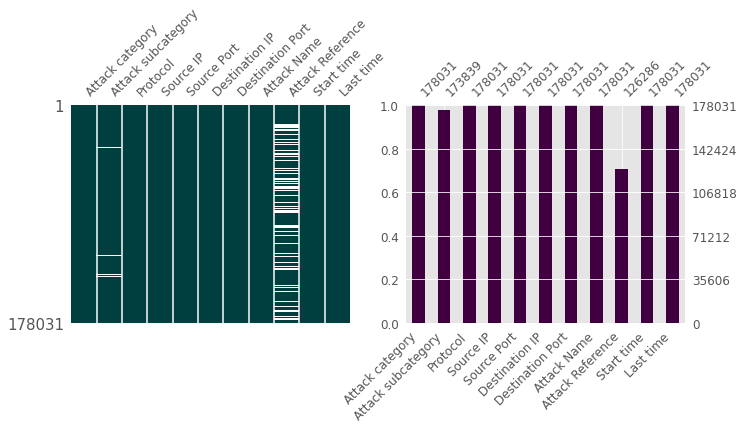

In [12]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
msno.matrix(df, ax=ax1, sparkline=False, fontsize = 12, color=(0., 0.25, 0.25))
msno.bar(df, ax=ax2, fontsize = 12, color=(0.25, 0., 0.25))
plt.show()

There are two columns within our dataset that present nonexistent data: the `Attack Reference` column (which has 29% of the observations missing) and the `Attack Subcattegory` column (which has 2% of the observations missing).

Handling ths missing data is a fundamental step in data cleaning. It is common that during the data acquisition processes, there are lost records, either due to the difficulties of acquiring them, due to errors in the source or destination, or because we simply could not acquire the data. There are three types of missing data:

- Missing completely at random (MCAR): when the fact that the data is missing is independent of the observed and unobserved data.
- Missing at random (MAR): when the fact that the data is missing is systematically related to the observed but not the unobserved data.
- Missing not at random (MNAR): when the missingness of data is related to events or factors which are not measured by the researcher.

There are four types of treatment that can be given, in that order, to unwanted non-existent or missing data in this context:

1. **Treatment 1:** Ignore the missing or unwanted data in some columns, considering that in other columns of the same rows there are important or relevant data for the study.
2. **Treatment 2:** Replace the missing or unwanted data with values that represent an indicator of nullity.
3. **Treatment 3:** Replace the missing, nonexistent or unwanted data with interpolated values that are related to the trend of the data that is present.
4. **Treatment 4:** Delete the missing data, with the certainty that valuable information will not be lost when analyzing the data.

Whenever we see missing values we must ask ourselves the question: **Why are these values missing?**. For now we will follow the procedure and apply a treatment to each of the columns. Later we will see the reason for these missing values.

We can apply **Treatment 2** and **Treatment 3** in-place using the ``isnull()`` method as a mask, but because it is such a common operation `Pandas` provides the ``fillna()`` method, which returns a copy of the array with the missing values replaced.

To display those rows that have null data in any of their columns, the following instruction can be executed: `df[pd.isnull(df).any(axis=1)].head()`. This allows slicing the DataFrame object with the indexes of the rows with null columns and shows a new DataFrame with just these rows:

In [13]:
df[pd.isnull(df).any(axis=1)].head(5)

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
258,Fuzzers,OSPF,ospf,175.45.176.3,0,149.171.126.14,0,"Fuzzer: OSPF Hello Packet: Invalid Length, Lon...",NaN,1421927643,1421927645
500,Fuzzers,BGP,tcp,175.45.176.2,63685,149.171.126.13,179,"BGP Header: Random Payload, Bad Length (https:...",NaN,1421927755,1421927755
501,Fuzzers,BGP,tcp,175.45.176.2,48413,149.171.126.13,179,"BGP Header: Random Payload, Bad Length (https:...",NaN,1421927755,1421927756
502,Fuzzers,BGP,tcp,175.45.176.2,30451,149.171.126.13,179,"BGP Header: Random Payload, Bad Length (https:...",NaN,1421927756,1421927756
503,Fuzzers,BGP,tcp,175.45.176.2,58077,149.171.126.13,179,"BGP Header: Random Payload, Bad Length (https:...",NaN,1421927756,1421927756


In this case, we will give the `Attack Subcategory` column the *Treatment 2*, since we may be interested in documenting which attacks are without classification. To replace null values with a nullity indicator, the `.fillna()` method can be used, which fills the null data of a Series object with a  parameter value. The result is a new Series object with the null data replaced.

We will give the `Attack Reference` column the *Treatment 1*, since we cannot risk losing useful data from other columns just by deleting those nulls, and the CVE information is not of interest to the study for the moment.

In [14]:
df["Attack subcategory"] = df["Attack subcategory"].fillna("Not Registered")

In [15]:
df.isnull().sum()

Attack category           0
Attack subcategory        0
Protocol                  0
Source IP                 0
Source Port               0
Destination IP            0
Destination Port          0
Attack Name               0
Attack Reference      51745
Start time                0
Last time                 0
dtype: int64

After ignoring, replacing, or removing null, unwanted, or non-existent data, we proceed to verify the existence of duplicate rows. These types of rows are not usually the object of study in data science analysis, pus normally represent redundancy of the data that generates noise in subsequent analysis. To check which columns are duplicated in a DataFrame object, the `.duplicated()` function is used, which returns the indices of the duplicate rows. With these indices we can proceed to filter the DataFrame:

In [16]:
df[df.duplicated()]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
32881,Exploits,Browser,ospf,175.45.176.1,0,149.171.126.16,0,Persits XUpload ActiveX Method MakeHttpRequest...,CVE 2009-3693 (http://cve.mitre.org/cgi-bin/cv...,1424223999,1424224029
40645,Exploits,Browser,ospf,175.45.176.3,0,149.171.126.13,0,Persits XUpload ActiveX Method MakeHttpRequest...,CVE 2009-3693 (http://cve.mitre.org/cgi-bin/cv...,1424227562,1424227593
61710,Exploits,Browser,ospf,175.45.176.3,0,149.171.126.18,0,Persits XUpload ActiveX Method MakeHttpRequest...,CVE 2009-3693 (http://cve.mitre.org/cgi-bin/cv...,1424231161,1424231205
115911,Exploits,Browser,sctp,175.45.176.3,0,149.171.126.18,0,Persits XUpload ActiveX Method MakeHttpRequest...,CVE 2009-3693 (http://cve.mitre.org/cgi-bin/cv...,1424246344,1424246344
122923,Exploits,Browser,sep,175.45.176.3,0,149.171.126.18,0,Persits XUpload ActiveX Method MakeHttpRequest...,CVE 2009-3693 (http://cve.mitre.org/cgi-bin/cv...,1424249567,1424249567
148693,Exploits,Browser,sctp,175.45.176.3,0,149.171.126.18,0,Persits XUpload ActiveX Method MakeHttpRequest...,CVE 2009-3693 (http://cve.mitre.org/cgi-bin/cv...,1424256448,1424256450


As we can see, there are six duplicated rows throughout the dataset that we will proceed to drop as follows:

In [17]:
print('Dimensions before dropping duplicated rows: ' + str(df.shape))
df = df.drop(df[df.duplicated()].index)
print('Dimensions after dropping duplicated rows: ' + str(df.shape))

Dimensions before dropping duplicated rows: (178031, 11)
Dimensions after dropping duplicated rows: (178025, 11)


In [18]:
df[df.duplicated()]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time


As shown, six repeated rows were dropped.

### Exercise 1 (10 minutes)

If during the dropping of duplicate rows, 2249 rows were dropped from the 6 found what would this have meant?

(a) That the `.duplicated()` function returned six results by default and you should have specified a different number of rows otherwise.

(b) That the `.duplicated()` function returned rows that were repeated only once, it doesn't matter if the same row was repeated *n* times in the dataset.

(c) That the `.duplicated()` function only looked for repeated rows in the top 50% of the dataset and the other 2,243 rows were in the bottom 50% of the dataset.

(d) That the `.duplicated()` function looked for duplicates in columns and not in rows, which is why the output cannot exceed the number of columns in the dataset.

**Answer:** 

The third step in the data cleaning process is the standardization of the columns. When a column is standardized, it is sought that the format and expression of the data is homogeneous and comparable. 

Let's start by analizing the data related to source and destination ports. The preprocessing procedure for cleaning the numerical values related with the ports involves the checking for numerical values that are outside the $[0, 65535]$ interval:

In [19]:
mask1 = (df['Source Port'] < 0) | (df['Source Port'] > 65535)
mask2 = (df['Destination Port'] < 0) | (df['Destination Port'] > 65535)
df[mask1 | mask2]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
174347,Generic,IXIA,udp,175.45.176.1,67520,149.171.126.18,53,Microsoft_DNS_Server_ANY_Query_Cache_Weakness_...,CVE 2005-4092 (http://cve.mitre.org/cgi-bin/cv...,1421933561,1421933561
174348,Exploits,Browser,tcp,175.45.176.3,78573,149.171.126.18,110,Microsoft Internet Explorer 6.0 Png pngfilt.dl...,BPS 2010-0002 (https://strikecenter.bpointsys....,1421932490,1421932491
174349,Reconnaissance,HTTP,tcp,175.45.176.1,71804,149.171.126.10,80,Domino Web Server Database Access: /internet.n...,NaN,1424236143,1424236143
174350,DoS,Ethernet,pnni,175.45.176.3,0,149.171.126.19,-753,Cisco IPS Jumbo Frame System Crash (https://st...,CVE 2008-2060 (http://cve.mitre.org/cgi-bin/cv...,1424230284,1424230284
174351,Fuzzers,OSPF,trunk-1,175.45.176.0,73338,149.171.126.13,0,Fuzzer: OSPF Hello Packet: Long Neighbor Lists...,NaN,1424223172,1424223172
...,...,...,...,...,...,...,...,...,...,...,...
178026,Generic,IXIA,udp,175.45.176.0,72349,149.171.126.12,53,Microsoft_DNS_Server_ANY_Query_Cache_Weakness_...,CVE 2009-0234 (http://cve.mitre.org/cgi-bin/cv...,1424224338,1424224338
178027,Exploits,Browser,sep,175.45.176.3,67647,149.171.126.18,0,Persits XUpload ActiveX Method MakeHttpRequest...,CVE 2009-3693 (http://cve.mitre.org/cgi-bin/cv...,1424249567,1424249567
178028,Exploits,Office Document,tcp,175.45.176.0,78359,149.171.126.13,110,Microsoft Excel SxView Memory Corruption (POP3...,CVE 2009-3128 (http://cve.mitre.org/cgi-bin/cv...,1424219921,1424219923
178029,Exploits,Browser,tcp,175.45.176.2,68488,149.171.126.19,80,Internet Explorer createTextRange() Code Execu...,CVE 2006-1359 (http://cve.mitre.org/cgi-bin/cv...,1424247789,1424247789


There are 3684 observations that are outside the logical range of the source and destination ports, which we will discard from our dataset, and reset our sample index:

In [20]:
df = df[~(mask1 | mask2)].reset_index(drop=True)

Let's now review the different protocols stored in our dataset, reviewing the first 10:

In [21]:
print('Total number of different protocols:', len(df['Protocol'].unique()))
print('Total number of different Attack categories:', len(df['Attack category'].unique()))
df['Protocol'].unique()[:10]

Total number of different protocols: 131
Total number of different Attack categories: 14


array(['tcp', 'udp', 'Tcp', 'UDP', 'ospf', 'sctp', 'sep', 'mobile',
       'sun-nd', 'swipe'], dtype=object)

We can see that there are 14 different attack categories and 131 different protocols associated with the observations. However, as we see in these first 10 protocols, there are the same that are spelled differently, such as 'tcp' and 'Tcp', or 'udp' and 'UDP'. 

The next step in this cleaning process is to homogenize all these forms of spelling so that we refer to the same group of protocols.

The preprocessing procedure for cleaning the string values is as follows:

- Express all the strings in the same way: lowercase, uppercase, first with uppercase, Camel notation, or any other chosen format. In this case, we will express all the strings of the columns `Protocol` and `Attack category` in a uppercase (using the `.upper()` function) and without spaces at the beginning or at the end of the strings (using the `.strip()` function).
- Write the terms, strings and words's stems rather than plurals, singulars or any verbal form different from infinitive. For instance, the words *Backdoors* and *Backdoor* refer to the same term, whether it is in the plural or singluar. For this reason, it is desirable to standardize the spelling. This can be done by replacing all those strings that are in a different script, so that they are written homogeneously, using the `.replace()` function. More advance natural language processing techniques such as *stemming* and *lemmatization* can be used for this task, although we will not review them for now. 

In [22]:
df['Protocol'] = df['Protocol'].str.upper().str.strip()
df['Attack category'] = df['Attack category'].str.upper().str.strip()
df['Attack category'] = df['Attack category'].str.strip().replace('BACKDOORS','BACKDOOR')
df_interest = df.copy()
df_interest.head(5)

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,1421927414,1421927416
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,1421927415,1421927415
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,1421927416,1421927416
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,1421927417,1421927417
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,1421927418,1421927418


In [23]:
print('Total number of different protocols:', len(df['Protocol'].unique()))
print('Total number of different Attack categories:', len(df['Attack category'].unique()))

Total number of different protocols: 129
Total number of different Attack categories: 9


We've reduced the number of attack categories from 14 to 9, and the number of distinct protocols from 131 to 129. 

Now that we have homogenized the spelling forms of the protocols and attack categories, let's look at the distribution of missing values again to specify the reason why they occur:

In [24]:
# Percentage of missing values in 'Attack Reference' per Attack Category
((df[pd.isnull(df['Attack Reference'])]['Attack category'].value_counts()/df['Attack category'].value_counts())*100).dropna().sort_values(ascending=False)

RECONNAISSANCE    90.132102
FUZZERS           88.141388
ANALYSIS          85.964912
SHELLCODE         49.437459
WORMS              6.508876
GENERIC            1.717019
BACKDOOR           1.516196
DOS                0.215605
EXPLOITS           0.007330
Name: Attack category, dtype: float64

We see that there is a substantial difference between the first 4 cybersecurity attacks and the last 5 types of registered attacks. If we go into reviewing the reference of each attack category in the CVE (Common Vulnerabilities and Exposures) we find the following:


|     Attack     | Number of CVE documents |
|----------------|-------------------------|
|        FUZZERS |                        3|
|       ANALYSIS |                        7|
|      SHELLCODE |                       16|
| RECONNAISSANCE |                       26|
|       BACKDOOR |                      161|
|        GENERIC |                      176|
|          WORMS |                      453|
|            DOS |                     6991|
|       EXPLOITS |                    12514|

These are the results of an analysis of Natural Language Processing of each of the CVE documents that talk about the categories of associated attacks (dataset for the analysis taken from: https://cve.mitre.org/data/downloads/ index.html). We can see that the first four categories of attacks in which no further CVE documentation is evident are those that do not record data from this reference. This is the rationale for the missing data, so this is why we have not removed the observations.

**3. Dataset Enriching**

<br>
<font color=#090060>
After cleaning, the data is enriched by increasing some variables in what is known as <b>Data Augmentation</b> and using additional sources to enrich them for the next stages of processing.
</font>
<br>

For the enrichment process, we are going to load a second dataset from the file `TCP-ports.csv`, in which the most known TCP ports are related, with the IT service that they attend and a short description of them:

In [25]:
tcp_ports = pd.read_csv('TCP-ports.csv')
tcp_ports['Service'] = tcp_ports['Service'].str.upper()
tcp_ports.head(10)

,Port,Service,Description
0,0,NaN,Reserved
1,1,TCPMUX,TCP Port Service Multiplexer
2,2,COMPRESSNET,Management Utility
3,3,COMPRESSNET,Compression Process
4,5,RJE,Remote Job Entry
5,7,ECHO,Echo
6,9,DISCARD,Discard
7,11,SYSTAT,Active Users
8,13,DAYTIME,Daytime
9,15,NaN,Unassigned [was netstat]


With this new data, we would like to merge the initial cybersecurity attack dataset with this TCP services data. This can be accomplished using the built-in pandas method `pd.merge()`, a versatile method to join DataFrames.

For those who are familiar with SQL, merging DataFrames can be accomplished in the same way that SQL performs these tasks (if you are not familiar with SQL, don't worry you don't need to know this for further analysis). In this case, we would like to use the `port` foreign key in both DataFrames objects `df_interest` and `tcp_ports`. We will only do this merge on the left that is, keeping the data of the DataFrame object `df_interest`:

In [26]:
print('Dimensions before merging dataframes: ' + str(df_interest.shape))

df_interest = pd.merge(df_interest, tcp_ports[['Port','Service']], left_on='Destination Port', right_on='Port', how='left')
df_interest = df_interest.rename(columns={'Service':'Destination Port Service'})

print('Dimensions after merging dataframes: ' + str(df_interest.shape))

Dimensions before merging dataframes: (174341, 11)
Dimensions after merging dataframes: (174341, 13)


We have used the `.rename()` function to rename the `Service column` to `Destination Port Service` for better understanding. 

When merging both DataFrames with a left join, the rows of the first DataFrame remain and two columns are added. This is because the joined DataFrame has one additional column, and the `port` column, although is the merging column, has a different name hence it is also added. To prevent this column from being redundant, we can remove it with the `.drop()` function:

In [27]:
df_interest = df_interest.drop(columns=['Port'])
df_interest.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,1421927414,1421927416,HTTP
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,1421927415,1421927415,NaN
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,1421927416,1421927416,HTTP
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,1421927417,1421927417,PERSONAL-AGENT
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,1421927418,1421927418,HTTP


# Exploratory Data Analysis (EDA)

*The Exploratory Data Analysis (EDA) refers to the critical process of conducting initial data research to discover patterns, detect anomalies, test hypotheses, and verify assumptions with the help of summary statistics and graphical representations.*

## General analysis of cybersecurity attacks

Let's start our EDA by analyzing the categories of attacks recorded. We can use the `.unique()` function for this task, which allows to extract the spectrum of unique values of a Series object:

In [28]:
df_interest['Attack category'].unique()

array(['RECONNAISSANCE', 'EXPLOITS', 'DOS', 'GENERIC', 'SHELLCODE',
       'FUZZERS', 'WORMS', 'BACKDOOR', 'ANALYSIS'], dtype=object)

Now that we know the attack categories, we are going to extract the number of observations regarding this categories using the method `.value_counts()`, which counts the matches of each of the data in a Series object:

In [29]:
df_interest['Attack category'].value_counts()

EXPLOITS          68211
FUZZERS           33638
DOS               24582
RECONNAISSANCE    20136
GENERIC           19860
BACKDOOR           4353
ANALYSIS           1881
SHELLCODE          1511
WORMS               169
Name: Attack category, dtype: int64

Let us now express these values in percentage terms in order to make the counts comparable values:

In [30]:
df_interest['Attack category'].value_counts()*100/df_interest['Attack category'].value_counts().sum()

EXPLOITS          39.125048
FUZZERS           19.294371
DOS               14.099954
RECONNAISSANCE    11.549779
GENERIC           11.391468
BACKDOOR           2.496831
ANALYSIS           1.078920
SHELLCODE          0.866692
WORMS              0.096936
Name: Attack category, dtype: float64

We can show that the values are sorted in descending order by default, sinc the `.value_counts()`. For further analysis it is convenient to plot the results for better understanding, hence wi will use the `.barplot()` function from `seaborn` to visualize the above results, and the `.plot(kind = 'pie')` function from `` pandas`` to visualize the Top 5 percentages:

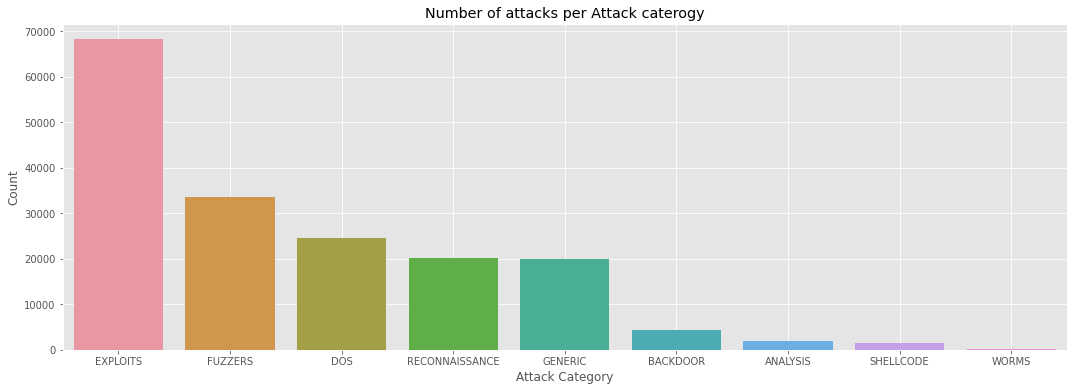

In [31]:
plt.figure(figsize=(18,6))
sns.barplot(x=df_interest['Attack category'].value_counts().index,y=df_interest['Attack category'].value_counts())
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.title('Number of attacks per Attack caterogy')
plt.grid(True)

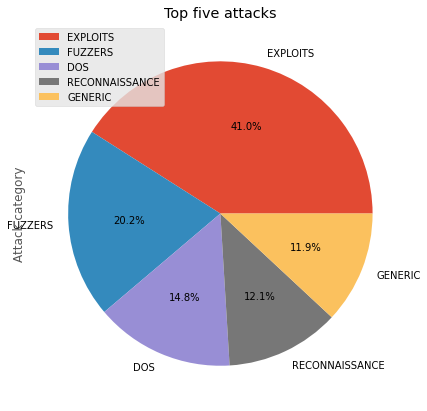

In [32]:
pd.DataFrame(df_interest['Attack category'].value_counts())[:5].plot(kind='pie', y='Attack category', figsize=(7, 7), autopct='%1.1f%%')
plt.title('Top five attacks')
plt.legend(loc='upper left')
plt.show()

It appears that the majority of attacks are *exploits*, followed by *fuzzers* and *Denial of Service* attacks. We will now run a **Data Augmentation** step to expand the time information, adding a column relative to the duration in seconds of the logged event:

In [33]:
df_interest['Start time'] = pd.to_datetime(df_interest['Start time'], unit='s')
df_interest['Last time'] = pd.to_datetime(df_interest['Last time'], unit='s')
df_interest['Duration'] = ((df_interest['Last time'] - df_interest['Start time']).dt.seconds).astype(int)

We have accessed the datetime data using the `dt` attribute. Before continuing with the analysis, it is important to be clear about the time frame that we are analyzing. We can extract this data as follows:
1. We extract the String that represents the start time, transforming the column to string with the `.astype(str)` function and the attribute `.str`.
2. We split the string into two parts by the ` ` character with the `.split(' ')` function, since it is expressed as 'Day Time'.
3. We extract the first portion of the string before the space with the attribute `.str[0]`
4. We extract the unique dates with the method `.unique()`.

In [34]:
df_interest['Start time'].astype(str).str.split(' ').str[0].unique()

array(['2015-01-22', '2015-02-18'], dtype=object)

Considering the above output, we can affirm that the analysis that we are going to execute from now on is based on information related to two days, Thursday - January 22nd/2015, and on Wednesday - February 18th/2015.

Now, we are going to list the statistical summary of the data that we have so far. We can do this using the `.describe()` function, which lists the:

- **count:** number of non-missing values per numerical column
- **mean:** the mean of the numerical values in the columns
- **std:** the standard deviation of the numerical values in the columns
- **min:** the minimum value per numerical column
- **max:** the maximum value per numerical column
- **25%:** the value corresponding to the 25th percentile (i.e. quartile 1) per column
- **50%:** the value corresponding to the 50th percentile (i.e. the median or quartile 2) per column
- **75%:** the value corresponding to the 75th percentile (i.e. quartile 3) per column

In [35]:
df_interest.describe()

,Source Port,Destination Port,Duration
count,174341.000000,174341.000000,174341.000000
mean,15391.130382,1304.599423,2.341572
std,21707.824000,7466.035607,9.309381
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,31862.000000,80.000000,1.000000
max,65535.000000,65535.000000,60.000000


In order to show the linear relationships between the numerical columns in our DataFrame, we are going to use the `.corr()` function, which calculates pair-wise correlations using different methods. This coefficient is in the interval [-1, 1]. The closer the value is to 1, the stronger and positive the relationship is. The closer this coefficient is to -1, the relationship is said to be strong and negative.

We will be using two methods for correlation calculation:
- **Pearson's correlation:** evaluates the linear relationships between two variables. If the value is close to 0, there is a weak or nonexistent linear relationship between the variables.
- **Spearman's correlation:** evaluates the monotonic relationships between two variables. If the value is close to 0, there is a weak or nonexistent monotonic relationship between the variables.

In [36]:
df_interest.corr(method='pearson')

,Source Port,Destination Port,Duration
Source Port,1.000000,0.137155,-0.078024
Destination Port,0.137155,1.000000,-0.026770
Duration,-0.078024,-0.026770,1.000000


In [37]:
df_interest.corr(method='spearman')

,Source Port,Destination Port,Duration
Source Port,1.000000,0.885328,0.361013
Destination Port,0.885328,1.000000,0.346909
Duration,0.361013,0.346909,1.000000


We can see a substantial difference between Pearson's correlation and Spearman's correlation between source ports and destination ports. These results suggest that although the relationship between this pair of variables is linearly weak, there is a strong monotonic relationship between them.

In order to visualize these correlation values, we can plot them in a heatmap, using the method `.heatmap()`. We are going to convert the `'Attack category'` categorical variable into a dummy variable with `.get_dummies()` function the to have a bigger picture of our dataset:

In [38]:
df_dummies = pd.get_dummies(df_interest, columns=['Attack category'])

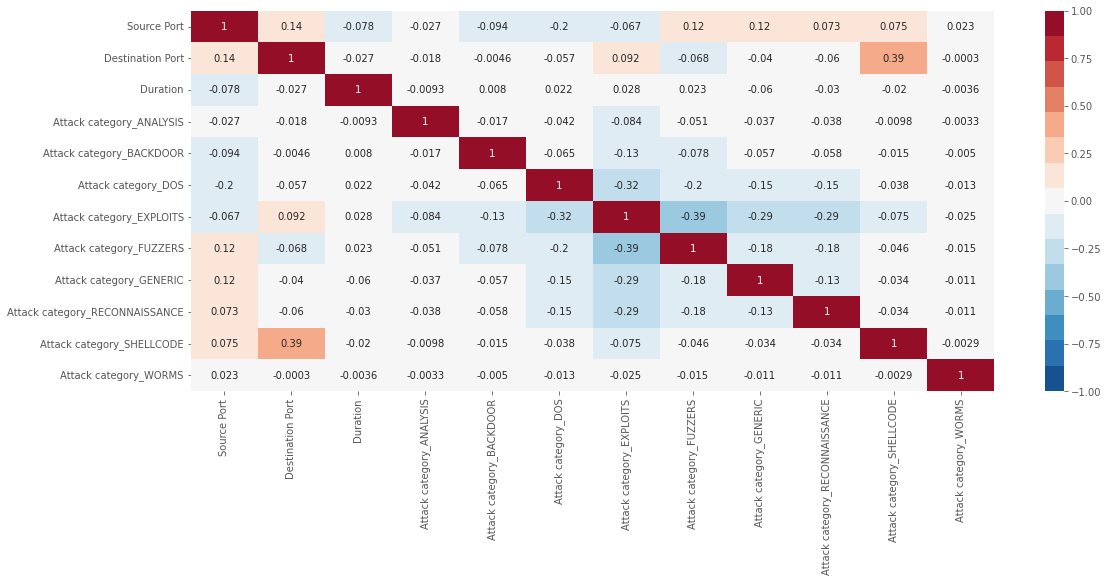

In [39]:
plt.figure(figsize=(18,7))
sns.heatmap(df_dummies.corr(method='pearson'), 
            annot=True, vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 15))
plt.show()

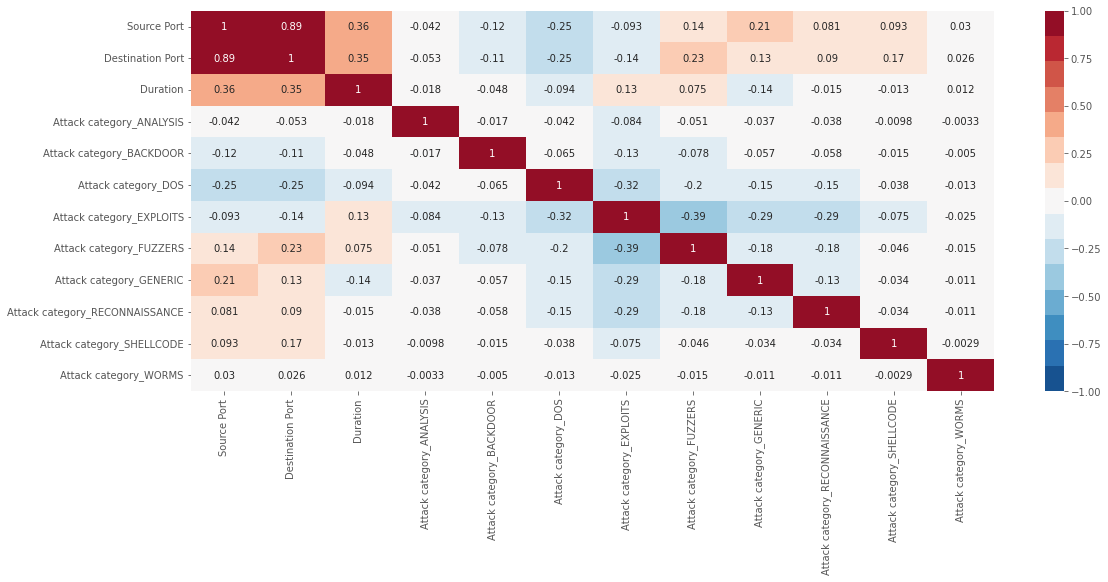

In [40]:
plt.figure(figsize=(18,7))
sns.heatmap(df_dummies.corr(method='spearman'), 
            annot=True, vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 15))
plt.show()

The warmer the colors, the less linear relationship the plotted variables have. The stronger the colors of blue and red are, the stronger is the proportional relationship between the variables. As we can see, the colors are considerably warm between the attack categories, indicating a weak linear relationship. The relationship between the ports is maintained and hence the colors are darker.

If we try to plot the pairwise relationships in the dataset with the `.pairplot()` function, we will obtain the following plot, which does not give further insight about the data:

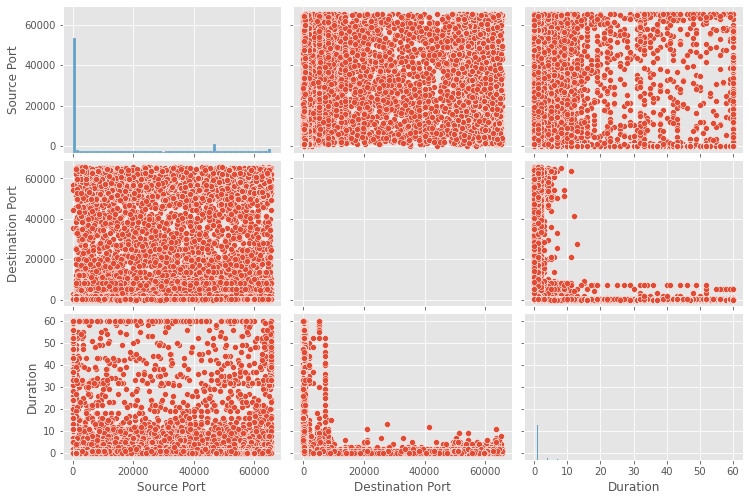

In [41]:
g = sns.pairplot(df_interest)
g.fig.set_size_inches(11,7)
plt.show()

## Datetimes analysis of cybersecurity attacks

For the analysis of cybersecurity attacks over time we will provisionally focus on the most concurrent server/machine in the dataset:

In [42]:
df_interest['Destination IP'].value_counts()[:5]

149.171.126.17    43199
149.171.126.10    24002
149.171.126.19    21619
149.171.126.13    20464
149.171.126.18    13301
Name: Destination IP, dtype: int64

The server/machine most times registered in the dataset is the one with IPv4 149.171.126.17. 

We are going to analyze what happens to this machine by making a scatterplot, where each attack corresponds to a point related to the destination port. We will do this using the `.scatterplot()` function:

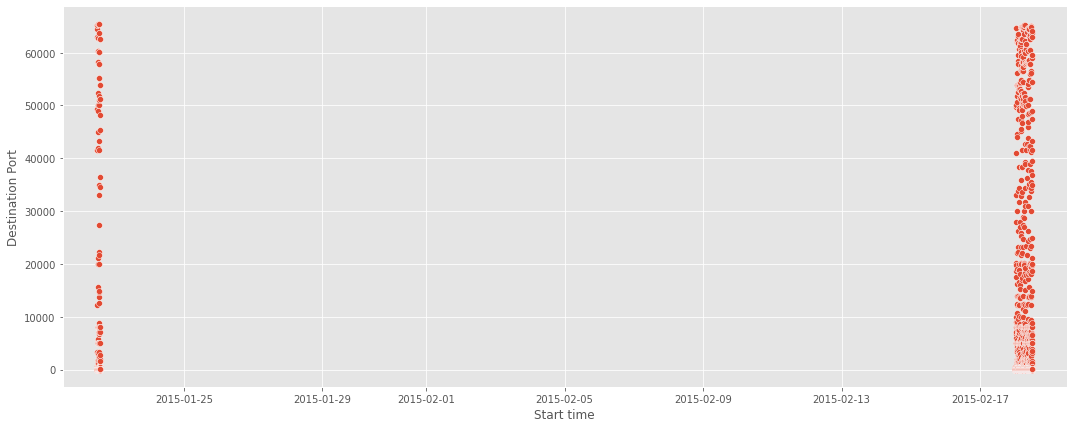

In [43]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=df_interest[df_interest['Destination IP']=='149.171.126.17']['Start time'], y=df_interest[df_interest['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=df_interest['Start time'].min()-timedelta(days=1),right=df_interest['Start time'].max()+timedelta(days=1))
plt.grid(True)
plt.show()

Now let's expand the two strips, both left and right, to see if there is any attack patterns. We can do this by specifying the *x* axis limit using the `.xlim()` function, knowing in advance the strip to which we want to zoom:

**Left zone:**

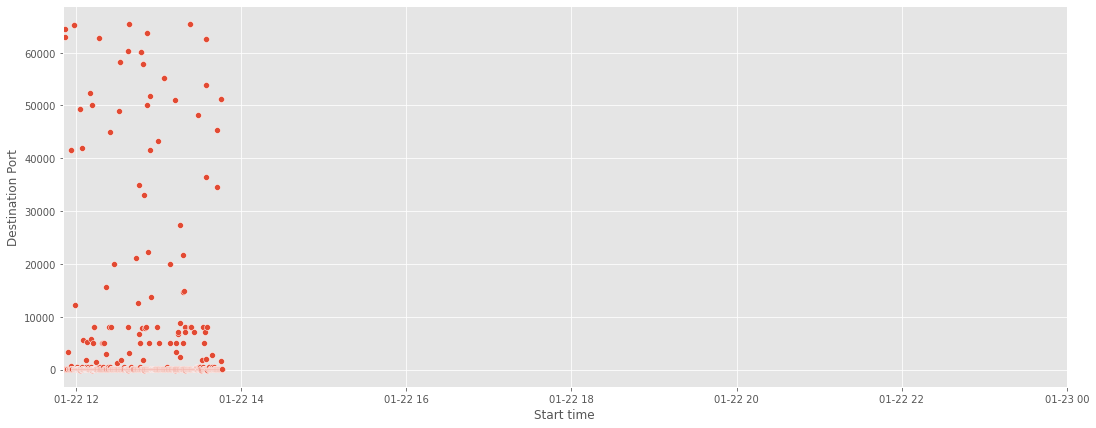

In [44]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=df_interest[df_interest['Destination IP']=='149.171.126.17']['Start time'], y=df_interest[df_interest['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=df_interest['Start time'].min(),right=datetime.strptime('15-01-23', '%y-%m-%d'))
plt.grid(True)
plt.show()

**Right zone:**

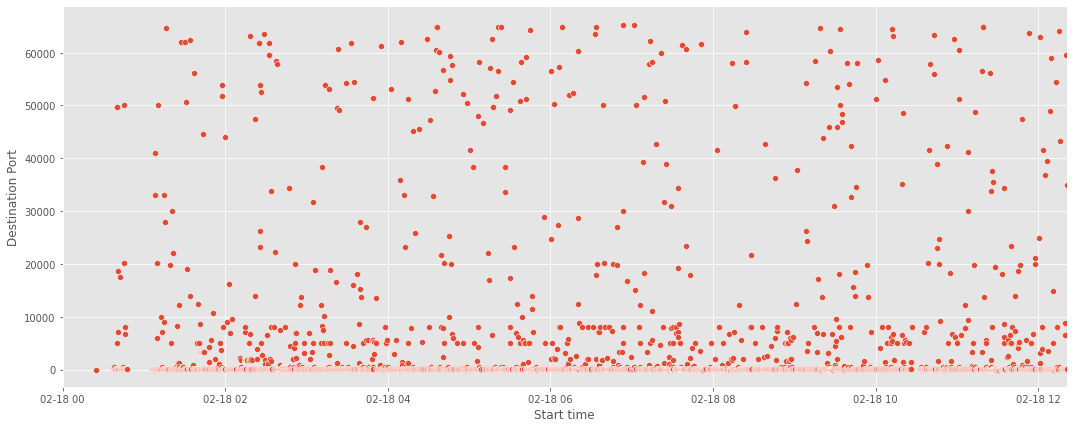

In [45]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=df_interest[df_interest['Destination IP']=='149.171.126.17']['Start time'], y=df_interest[df_interest['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=datetime.strptime('15-02-18', '%y-%m-%d'),right=df_interest['Start time'].max())
plt.grid(True)
plt.show()

There is high dispersion of Destination ports. Let's zoom in on the scatterplot when the attacks were executed on the first 150 ports, subsetting the dataframe with this condition. We are going to graph this part zoom in according to the attack categories using the `hue` parameter, which makes color discrimination of a third variable in the graph:

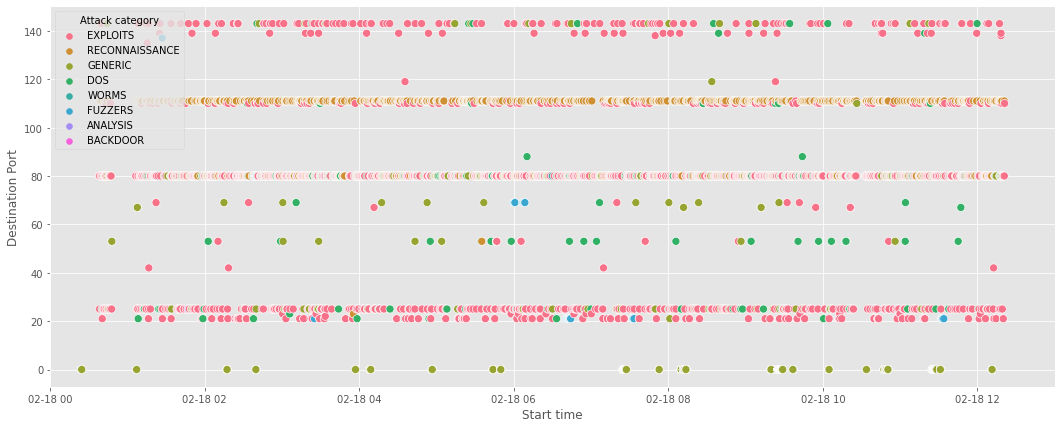

In [46]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Start time', y='Destination Port', hue='Attack category', 
                data=df_interest[(df_interest['Destination IP']=='149.171.126.17')&(df_interest['Destination Port']<=150)], 
                s=65)
plt.xlim(left=datetime.strptime('15-02-18 00:00:00', '%y-%m-%d %H:%M:%S'),
         right=datetime.strptime('15-02-18 13:00:00', '%y-%m-%d %H:%M:%S'))
plt.grid(True)
plt.show()

<h3><center>Do you see any relevant pattern in this plot?</center></h3>

In fact, there is an evident pattern in the graph in which nine clear constant trends are perceived on the values 0, 22, 25, 53, 80, 110, 111, 138 and 143 of the *y-axis*. This pattern corresponds to the very well known ports that provide important TCP and UDP services. For instance, the Denial of Service attacks on TCP/UDP port 53 which provides DNS domain services. Attacking this port would mean an inability to transfer the zones and achieve the domains validations, which would cause a total system crash.

We can also plot the dispersion of the cybersecurity event's duration in terms of the destination ports. It can be seen that for the lowest ports, among which the well-known ports are part, the attacks lasted less than one minute; while, as the port number grows, the duration of the events tends to decrease. Although it is not a line trend, as we have seen in the correlation matrix, there is a pattern that identifies its behavior over time.

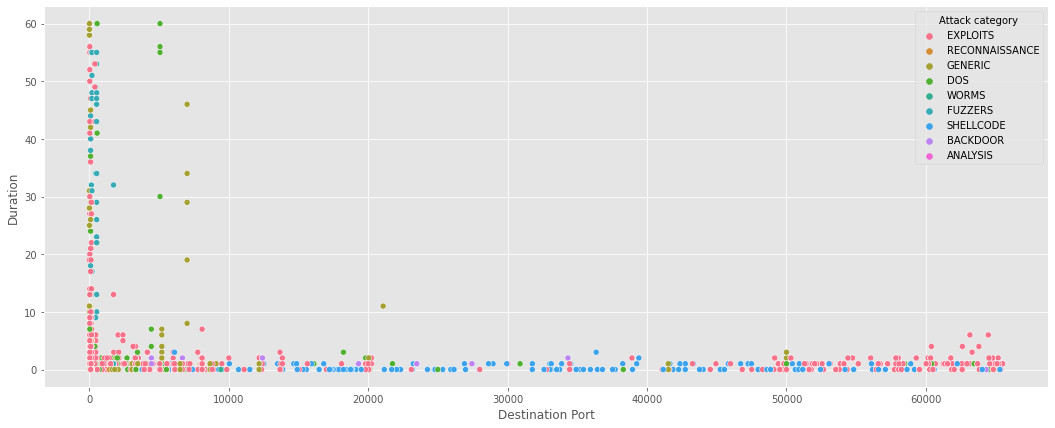

In [47]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Destination Port', y='Duration', hue='Attack category', data=df_interest[df_interest['Destination IP']=='149.171.126.17'])
plt.grid(True)
plt.show()

Let's review the distribution of the attacks duration's, which is shown in the following violin plot using the `.violinplot()` function:

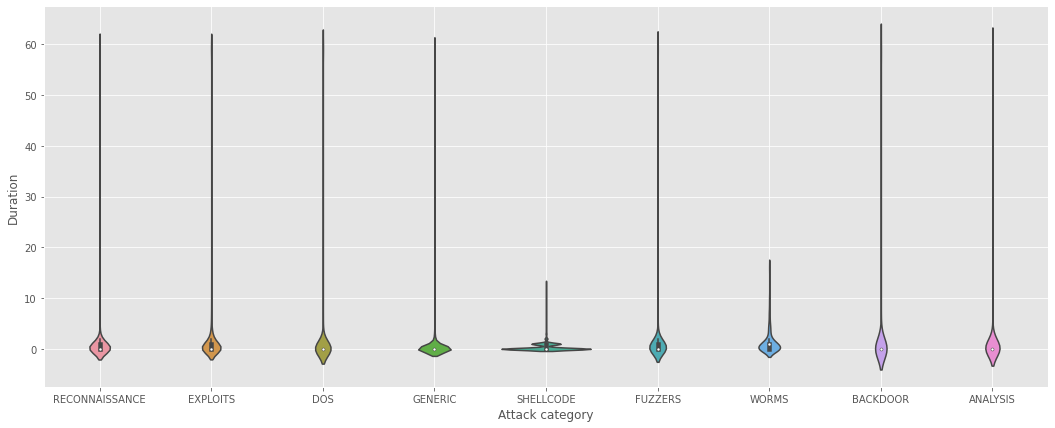

In [48]:
plt.figure(figsize=(18,7))
sns.violinplot(x='Attack category', y='Duration', data=df_interest, showfliers = False)
plt.grid(True)
plt.show()

There are two types of attacks that do not record times greater than 20 seconds, the *shellcode* and the *worms*. Most distributions are **normal distributions**, except for the one found in *shellcode*, which has two peaks, indicating a **bimodal distribution** (two different modes) in which duration values can be presented with alike probabilities of occurrence.

Now we will identify any relationship between the time the attacks were executed, and the attack category. This can be done through **Data Augmentation**, creating a new column related to the `hour` in which the attacks were performed. We are going to use the `.apply()` function and the `lambda` function. This allows us to execute our own operation for each of the rows. In this case, we will express the attack time in the format `hh:00:00`:

In [49]:
df_interest_pivot = df_interest.copy()
df_interest_pivot['hour'] = df_interest_pivot.apply(lambda row: '0'*(2-len(str(row['Start time'].hour)))+str(row['Start time'].hour)+':00:00', axis=1)

We are going to code a user-defined function that allows to plot heatmaps in an orderly and systematic way. We will define a function named `heatmap_graph`, which has four input arguments: `df` (DataFrame object), `xlabel` (x-axis label), `ylabel` (y-axis label) and `title` (chart title). This function will plot the heatmap using the `.heatmap()` function, rotating the *x-axis* labels using the `.xticks(rotatio = 90)`:

In [50]:
def heatmap_graph(df, xlabel, ylabel, title):
    plt.figure(figsize=(18,8))
    ax = sns.heatmap(df)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

To count the number of attacks that occur per hour and according to the attack category, we can use the `.pivot_table()` function, which allows to re-arrange the DataFrame object as defined in the function. Take a look to the table's pivoting:

In [51]:
df_p1 = pd.pivot_table(df_interest_pivot, 
                           values='Attack Name', 
                           index=['hour'], columns=['Attack category'], aggfunc='count')
df_p1

Attack category,ANALYSIS,BACKDOOR,DOS,EXPLOITS,FUZZERS,GENERIC,RECONNAISSANCE,SHELLCODE,WORMS
hour,,,,,,,,,
00:00:00,3,16,127,543,391,60,177,20,3
01:00:00,186,1148,2640,6716,4477,1748,1804,105,14
02:00:00,71,100,630,2861,1983,1031,1023,113,10
03:00:00,226,60,3755,9759,2743,1513,2727,113,17
04:00:00,64,87,617,2776,2090,1349,1034,115,10
05:00:00,198,645,3038,9368,2536,1834,1750,111,15
06:00:00,84,90,637,2968,2065,994,1010,116,9
07:00:00,179,578,3390,6151,2413,2076,1846,116,15
08:00:00,73,111,664,2938,2048,1081,1010,107,11


In the new DataFrame object, the columns now correspond to the attack category and the rows the the hour time of the attack. Now we are going to plot the heatmap by calling the function `heatmap_graph()` that we have defined:

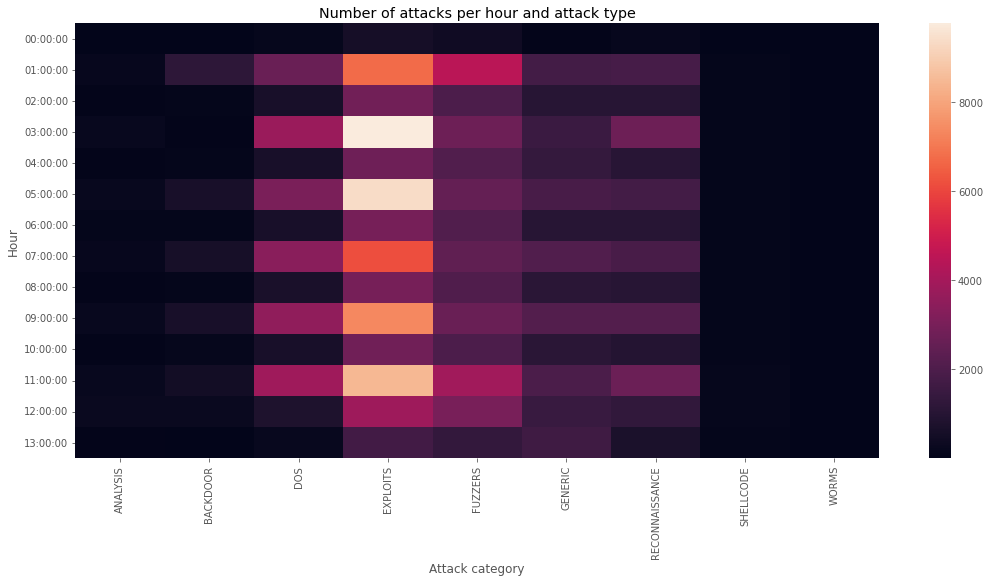

In [52]:
heatmap_graph(df = df_p1, xlabel = 'Attack category', ylabel = 'Hour', title = 'Number of attacks per hour and attack type')

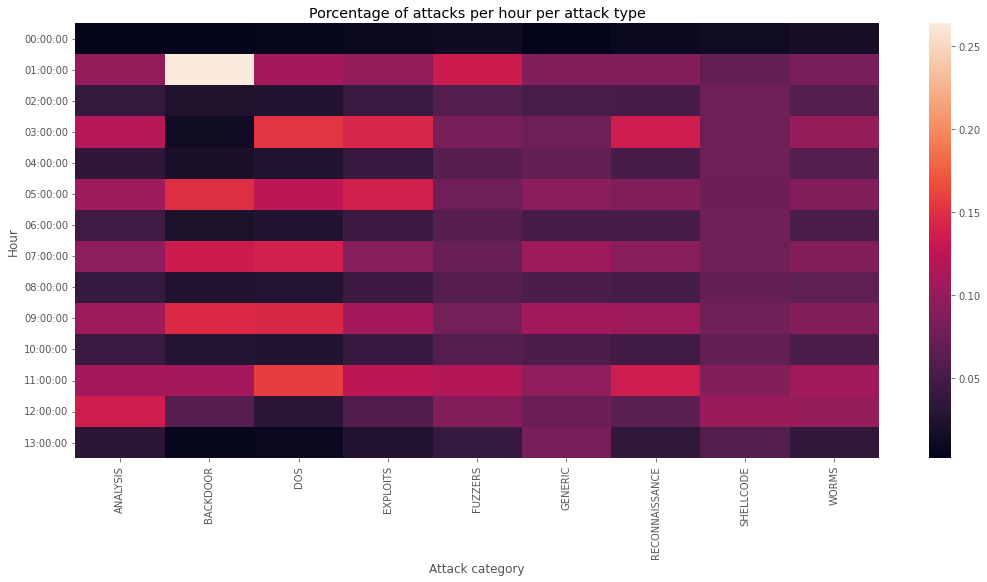

In [53]:
heatmap_graph(df = df_p1/df_p1.sum(), xlabel = 'Attack category', ylabel = 'Hour', title = 'Porcentage of attacks per hour per attack type')

We can notice a peculiar pattern in the attacks, especially for Denial of Service and Exploit attacks. The attacks were made with more intensity at odd hours throughout the daytime slot. 

Let's plot a second heatmap that relates the number of cybersecurity attacks, with the destination IPv4 addresses and the time of attack, in order to show which servers these attacks were directed to:

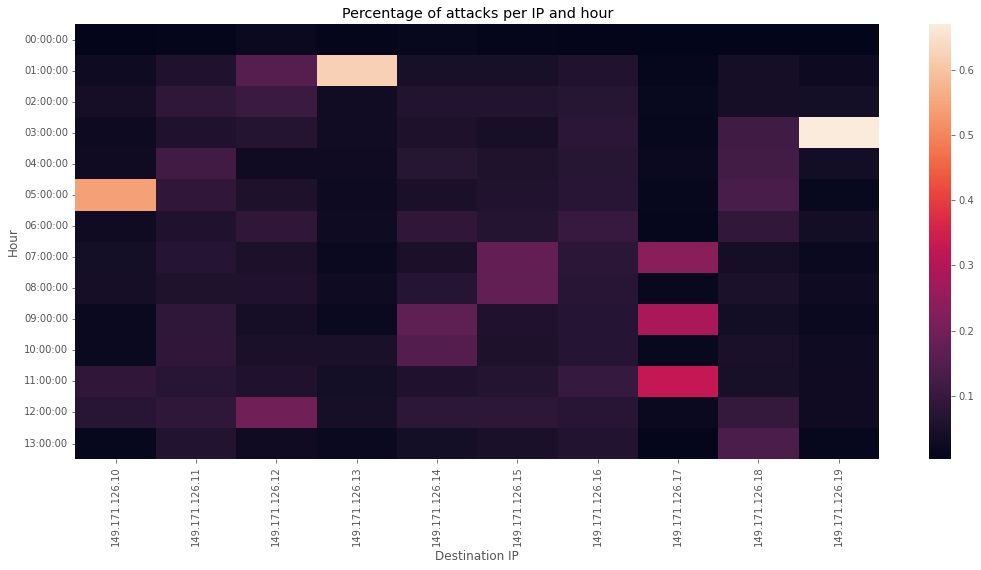

In [54]:
df_p2 = pd.pivot_table(df_interest_pivot, 
                           values='Attack Name', 
                           index=['hour'], columns=['Destination IP'], aggfunc='count')
heatmap_graph(df = df_p2/df_p2.sum(), xlabel = 'Destination IP', ylabel = 'Hour', title = 'Percentage of attacks per IP and hour')

Although there are more than 170,000 records related to cybersecurity attacks, these attacks target 10 servers with IPv4 addresses in the interval $[149.171.126.10, 149.171.126.19]$. This means that the company was attacked on multiple occasions during the observed timeframe, on a specific subnet, which denotes a non-accidental and directed succession of events.

Now let's look at the relationship between IPv4 addresses and attack categories:

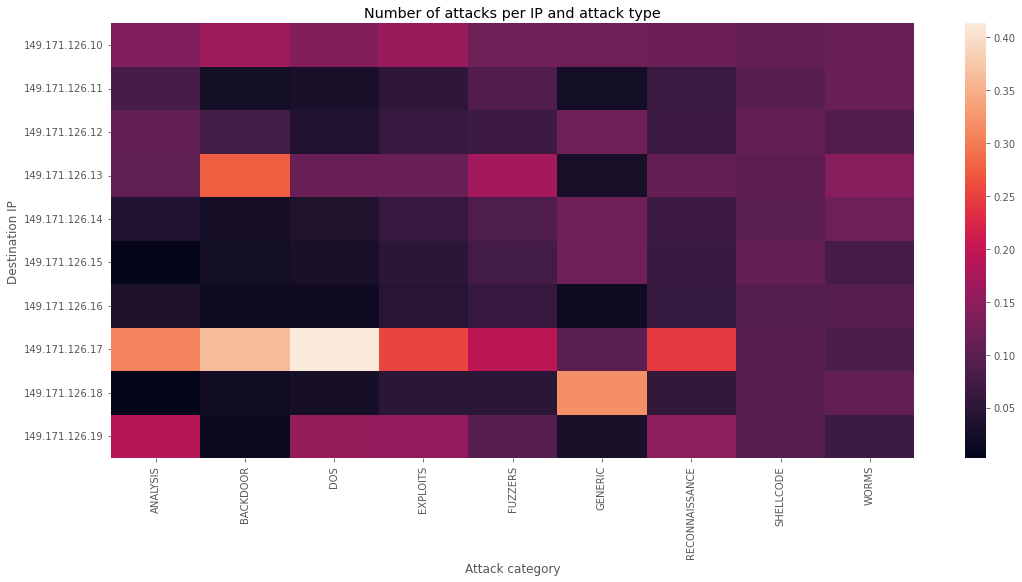

In [55]:
df_p3 = pd.pivot_table(df_interest_pivot, 
                           values='Attack Name', 
                           index=['Destination IP'], columns=['Attack category'], aggfunc='count')
heatmap_graph(df = df_p3/df_p3.sum(), xlabel = 'Attack category', ylabel = 'Destination IP', title = 'Number of attacks per IP and attack type')

The most attacked machine is the one with the IPv4 address 149.171.126.17. Conversely, while *worms*, *shellcode* and *generic* attacks are not directed at particular machines, *Denial of Services*, *Exploits* and *Backdoor* attacks are clearly targeted towards specific servers.

## Detailed analysis of logical ports

We are going to analyze the behavior of the source and destination logical ports during the cybersecurity attacks. Let's look again at the summary statistics of these ports with the `.describe()` function:

In [56]:
df_interest.describe()

,Source Port,Destination Port,Duration
count,174341.000000,174341.000000,174341.000000
mean,15391.130382,1304.599423,2.341572
std,21707.824000,7466.035607,9.309381
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,31862.000000,80.000000,1.000000
max,65535.000000,65535.000000,60.000000


There is a big difference in the mean of source ports (15391) and destination ports (1304) in cybersecurity attacks. In order to identify if this difference is **statistically significant**, that is, that it can be statistically verified with a level of **significance**, we will conduct a **Hypothesis Testing** on the difference in the averages of the source and destination ports.

In other words, we would like to statistically test whether the two group means are different from each other; that is, if the mean of the source ports of the cybersecurity attacks ($\mu_1$) are different from the mean of destination ports of the attacks ($\mu_2$). The testing procedure has two hypothesis statements $ H_0 $ and $ H_a $:

$$ H_0: \mu_1=\mu_2$$
$$ H_a: \mu_1\neq\mu_2$$

Being:
- $H_0$ the null hypothesis: the means of the source and destination ports are equal.
- $H_a$ the alternative hypothesis: the means of the source and destination ports are different.

This type of statistical tests report a **$p$-value**. This is a key value used to determine if the test results were or not statistically significant. We are going to introduce another variable $\alpha$ that corresponds to the significance level that will be set to $\alpha = 0.05$.

We can obtain one of two results from the test:

1. If the **$p$-value** is less than our significance level ($p<\alpha$) we reject the null hypothesis $H_0$ and affirm that the observed difference is **statistically significant**.
2. If the **$p$-value** is greater than our significance level ($p>\alpha$) we will have to retain $H_0$ and conclude that the observed difference **is not statistically significant**.

The hypothesis test is conducted using a statistical **$T-test$** which specifies the two Series `df_interest['Source Port']` and `df_interest['Destination Port']`. By specifying these two Series, we are automatically referring to a comparative test of the means of both Series:

In [57]:
statistic, pvalue = stats.ttest_ind(df_interest['Source Port'], df_interest['Destination Port'], equal_var=False)
print('p-value in T-test: ' + str(pvalue))

p-value in T-test: 0.0


Because the $p$-value is very close to zero, Python approximates this measurement to 0.0. With this in mind, we can reject the null hypothesis $H_0$ regarding the equality of the means of the source and destination ports. This means that the source port of the attacks is very different from the destination port. In this way, most attacks are directed at specific logical ports, which does not leave a random spot.

Let's now look at this same relationship per attack category performing a pair-wise **$T-test$**:

In [58]:
for attack in list(df_interest['Attack category'].unique()):
    df_attack = df_interest[df_interest['Attack category'] == attack].copy()
    statistic, pvalue = stats.ttest_ind(df_attack['Source Port'], df_attack['Destination Port'], equal_var=False)
    print('p-value in T-test for ' + attack + ' attack: ' + str(pvalue))

p-value in T-test for RECONNAISSANCE attack: 0.0
p-value in T-test for EXPLOITS attack: 0.0
p-value in T-test for DOS attack: 0.0
p-value in T-test for GENERIC attack: 0.0
p-value in T-test for SHELLCODE attack: 0.3205085348227197
p-value in T-test for FUZZERS attack: 0.0
p-value in T-test for WORMS attack: 4.246722648635902e-46
p-value in T-test for BACKDOOR attack: 4.8983630604388355e-17
p-value in T-test for ANALYSIS attack: 9.319524862935004e-87


As can be seen, the $p$-values of all but one attack category are very close to 0.0. This means that the attacks have been directed to the specific ports, except for the *Shellcode* attacks, whose null hypothesis cannot be rejected. For this type of attack there is a defined randomness, which means that the source and destination ports have similar averages.

To verify this statement, we will make use of a `contingency table` which allows to relate the count of a certain pair of variables, similar to how we saw the `.pivot_table()`:

In [59]:
df_crosstab = pd.crosstab(df_interest['Attack category'], df_interest['Destination Port'])
df_crosstab

Destination Port,0,10,21,22,23,25,31,42,53,67,...,65455,65460,65470,65479,65486,65497,65502,65511,65517,65535
Attack category,,,,,,,,,,,,,,,,,,,,,
ANALYSIS,1442,0,0,0,0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BACKDOOR,4000,0,7,0,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOS,20825,4,75,0,13,425,0,0,154,33,...,0,0,0,0,0,0,0,0,0,0
EXPLOITS,40143,0,2198,14,135,4412,0,21,209,98,...,2,2,2,2,2,4,2,2,2,0
FUZZERS,13355,0,758,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GENERIC,2612,0,26,6,0,427,0,0,13438,54,...,0,0,0,0,0,0,0,0,0,6
RECONNAISSANCE,8324,0,0,0,7,7,0,0,41,0,...,0,0,0,0,0,0,0,0,0,0
SHELLCODE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WORMS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We have generated the contingency table of `Attack type` versus `Target port` and note that the individual counts are not uniform. This allows to affirm our inference that there might be an interaction between these two variables. We can formally test whether the variations we observe reflect real differences or are just a by-product of randomness. There are many different ways to test, but we will focus on the most widely used test: the **Chi-square test**. The null hypothesis for the Chi-square test is as follows:

$$
H_0:\text {The attack category is independent of the destination port}
$$

Intuitively, *"independence between two variables"* means that the distribution of values of one variable remains the same even when the value of the second variable changes (and vice versa). In our case, this means that the proportions of the different attack categories remain the same, even when we look at different destination ports. The data seems to indicate otherwise, so let's discuss how to numerically summarize the data to formally examine the null hypothesis:

In [60]:
chi2, p_value, dof, expected = chi2_contingency(df_crosstab)
print("p-value of Chi-square test for Attack category vs. Destination Port =", p_value)

p-value of Chi-square test for Attack category vs. Destination Port = 0.0


The $p$-value is extremely small and therefore we reject the null hypothesis and conclude that the `attack category` and `destination port` are not independent. In other words, the `destination port` do not remain the same for different `attack categories`, what agrees with what we observe previously.

To visualize this relationship between these variables (`source port`, `destination port`, and `attack category`), we can initially make a scatterplot using the `.scatterplot()` function between the source and destination ports in terms of the attack category:

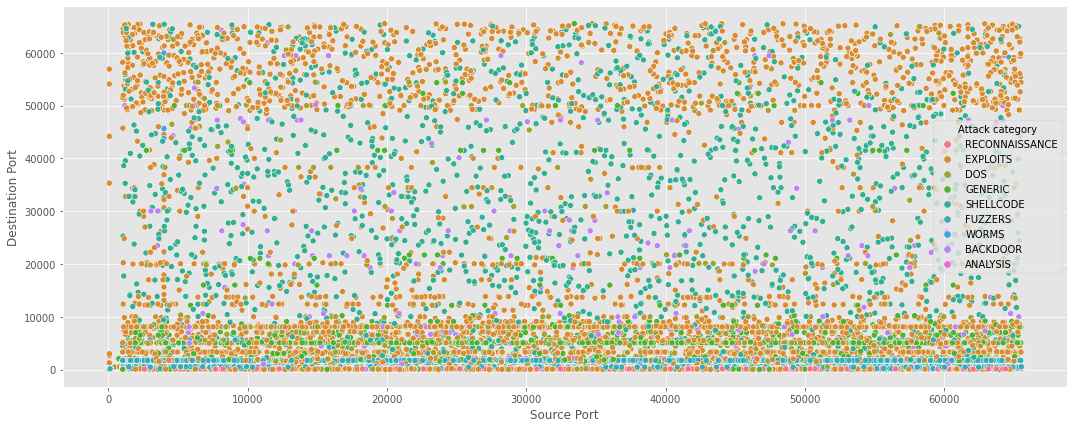

In [61]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Source Port',y='Destination Port', hue='Attack category',data=df_interest)
plt.show()

A certain pattern can be seen in the graph, in which attacks usually occur on ports less than 10,000 or greater than 50,000, except for shellcode-type attacks, as we had anticipated in the hypothesis test.

To see this relationship more in depth, we can visualize the the distribution of the logical origin and destination ports with a strip diagram using the `.stripplot()` function:

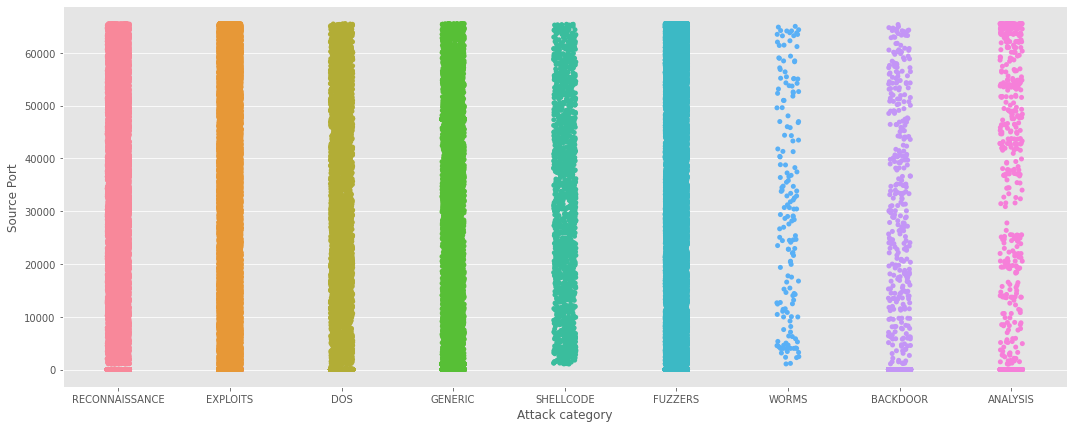

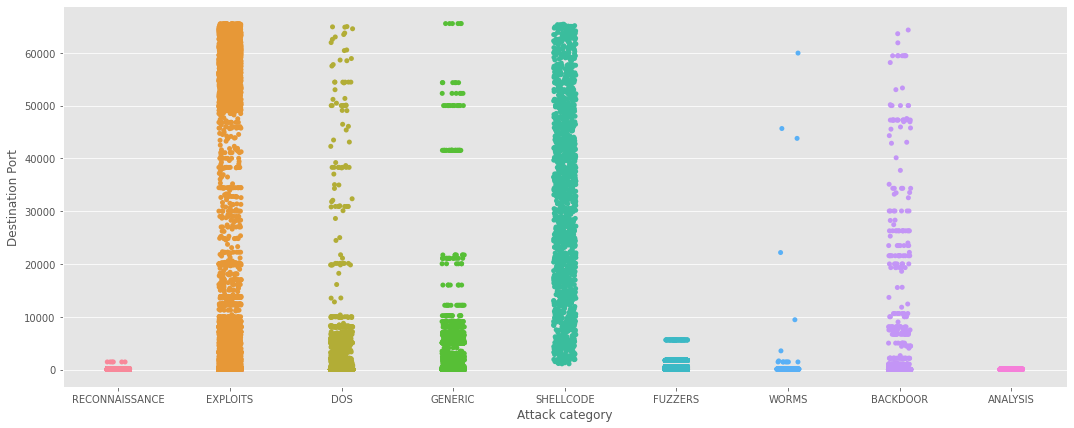

In [62]:
# Source ports
plt.figure(figsize=(18,7))
sns.stripplot(x='Attack category',y='Source Port',data=df_interest)
plt.show()

# Destination ports
plt.figure(figsize=(18,7))
sns.stripplot(x='Attack category',y='Destination Port',data=df_interest)
plt.show()

Let's see a disaggregated view of the distribution of destination ports by attack category and source IP:

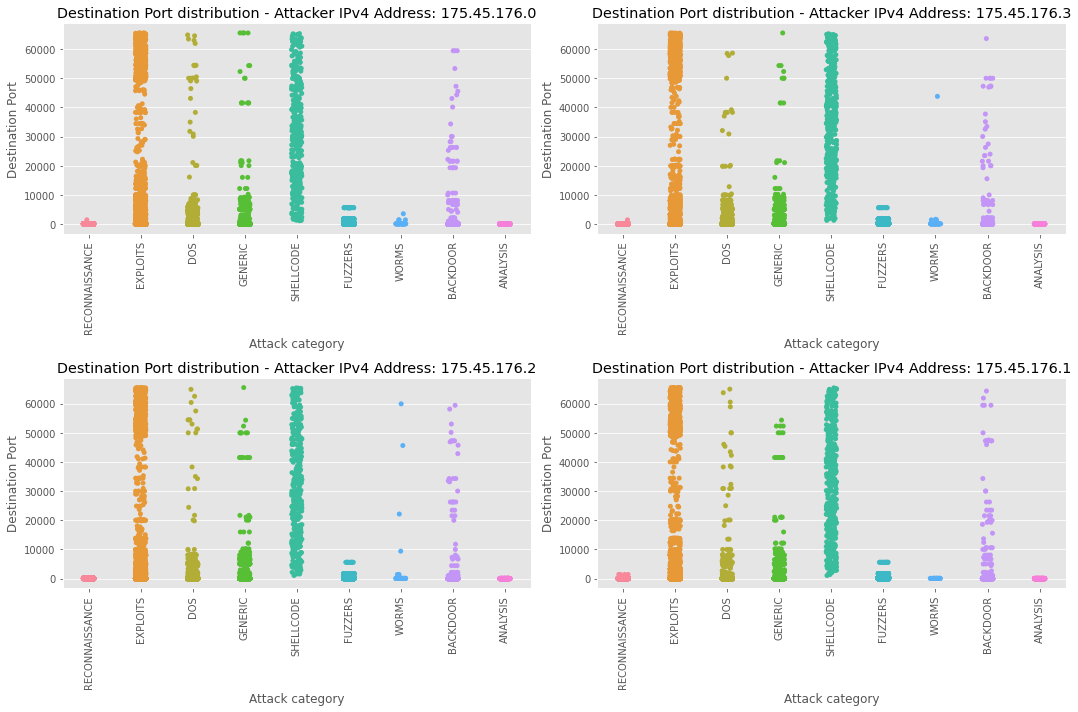

In [63]:
ips = list(df_interest['Source IP'].unique())
f, axes = plt.subplots(math.ceil(len(ips)/2), 2)
f.set_figheight(10)
f.set_figwidth(15)

labels = list(df_interest['Attack category'].unique())
for i, ip in enumerate(ips):
    sns.stripplot(x='Attack category',y='Destination Port',data=df_interest[df_interest['Source IP'] == ip], order=labels, ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_xlabel('Attack category')
    axes[int(i/2)][i%2].set_ylabel('Destination Port')
    axes[int(i/2)][i%2].set_title('Destination Port distribution - Attacker IPv4 Address: ' + ip)
    axes[int(i/2)][i%2].set_xticklabels(labels,rotation=90)
plt.tight_layout()
plt.show()

Let's see a disaggregated view of the distribution of destination ports by attack category and destination IP:

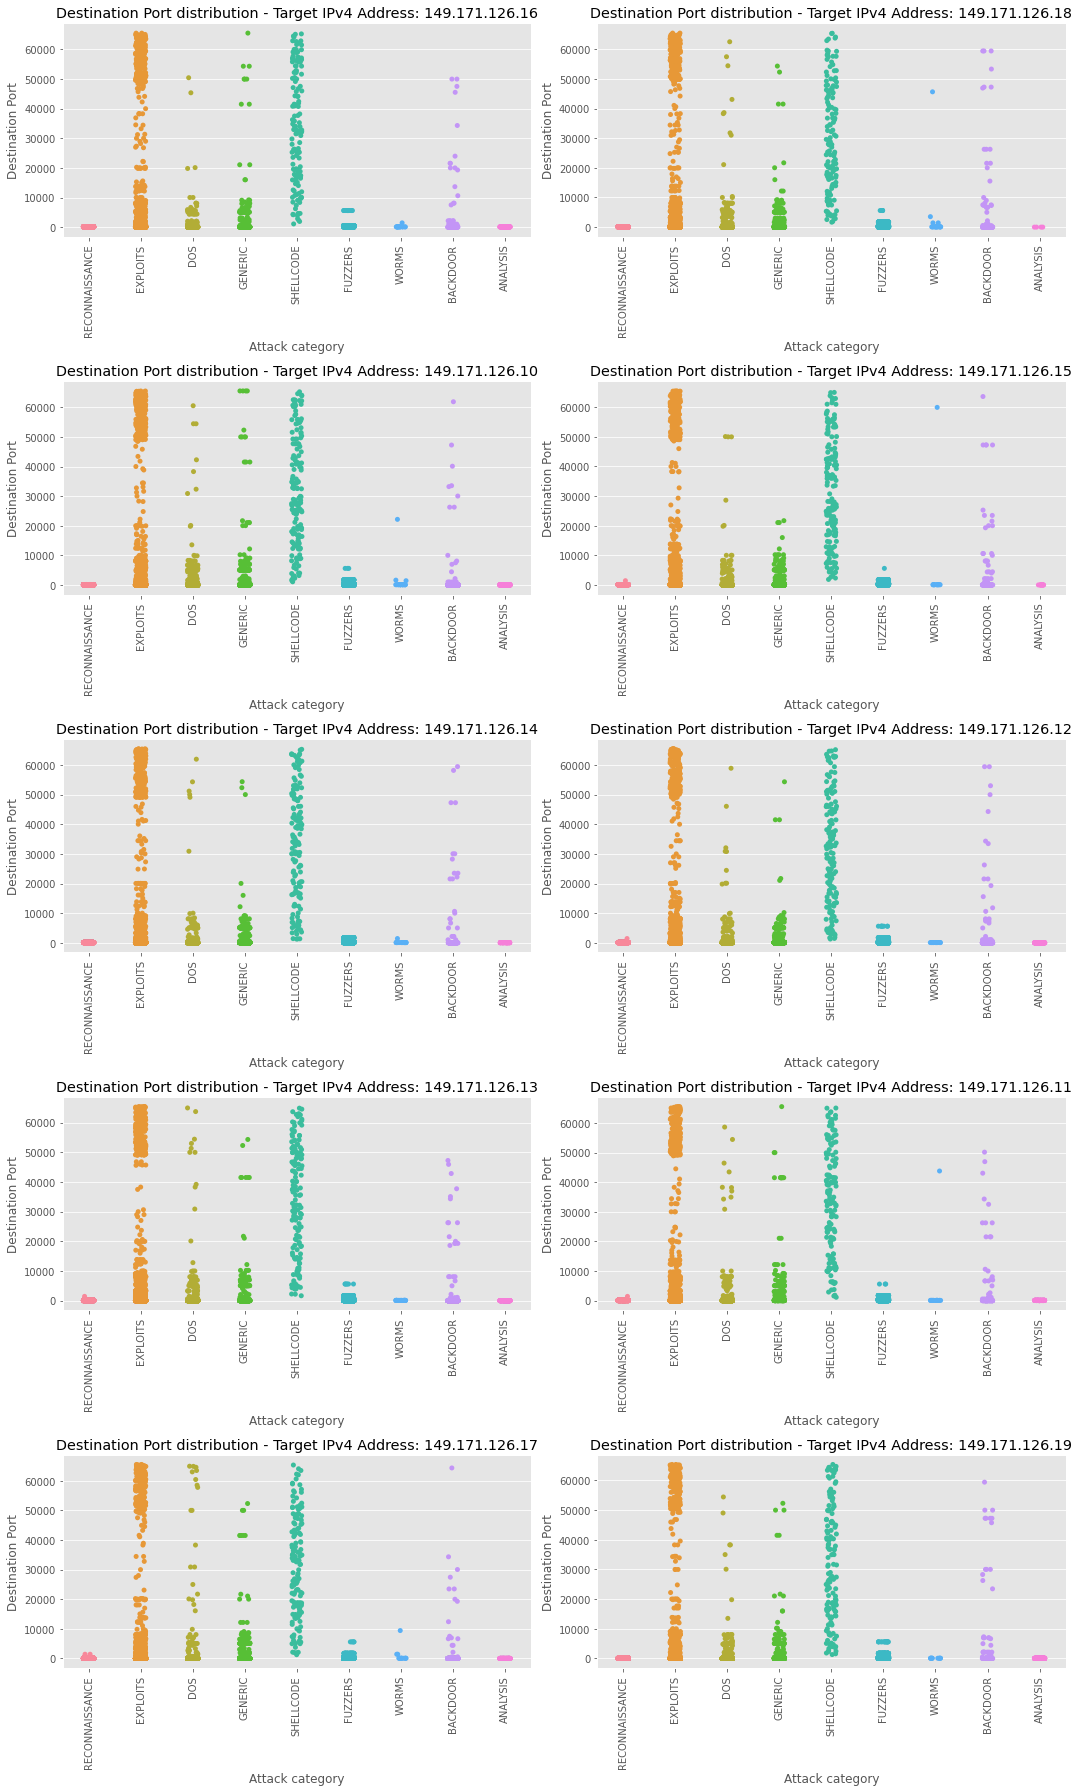

In [64]:
ips = list(df_interest['Destination IP'].unique())
f, axes = plt.subplots(math.ceil(len(ips)/2), 2)
f.set_figheight(25)
f.set_figwidth(15)

labels = list(df_interest['Attack category'].unique())
for i, ip in enumerate(ips):
    sns.stripplot(x='Attack category',y='Destination Port',data=df_interest[df_interest['Destination IP'] == ip], order=labels, ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_xlabel('Attack category')
    axes[int(i/2)][i%2].set_ylabel('Destination Port')
    axes[int(i/2)][i%2].set_title('Destination Port distribution - Target IPv4 Address: ' + ip)
    axes[int(i/2)][i%2].set_xticklabels(labels,rotation=90)
plt.tight_layout()
plt.show()

These graphs show us that there is a differentiation in the way in which the attacks are performing their tasks. There is a particularization by the targets, something that does not happen with the source devices.

## Conclusions

In this use case, we have learned to:
- Work with the Python `` pandas`` package, extracting useful data that may give and orientation for further cybersecurity analysis.
- Plot the data on multiple graphs using the `seaborn` package.
- Interpret the numerical and graphical results.
- Run hypothesis testing to validate statistically significant differences between means of multiple variables.

Having plooted and analyzed the data, we were able to identify the pattern of various types of cybersecurity attacks, relating their behavior over time, in duration, and in the distribution of origin and destination ports. The procedure explained here can be extrapolated for all types of cybersecurity studies in which cybersecurity attack data records are kept, which can provide great information on what patterns occur and how to effectively ensure services and servers.